<a href="https://colab.research.google.com/github/moesmoesie/cr-assignment-02/blob/main/ModelBased_VS_ModelFree_RL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

We are going to simulate reinforcement-learning perform a variant of popular paradigm known as the 'two-step' task. In this task, participants have to make repeated decisions in order to receive a reward. To make the task more fun for our participants, we have embedded the task in a space travel setting! On each trial of the task participants choose one spaceship from a pair of spaceships. The chosen spaceship then takes the participant to either a red or a purple planet. There they encounter an alien. If the participant interacts with the alien, there is chance that they will receive a reward in the form of space treasure!

Specifically, there are two pairs of spaceships that each appear in their own 'first-stage' state. For each pair, one spaceship will always transition to the red planet, and the other always to the purple planet. Below is a schematic of this structure, in _cursive_ are the variables we will use to keep track of the different states (s1 and s2) and values for actions (Qmf1 and Qmf2):

![Task_structure](https://github.com/anne-urai/Model-free_Model-based_Workshop/blob/main/Figures/task_structure_text.png?raw=1)

_Stimuli adapted from Decker et al. 2016_

So each trial starts with seeing one of the two pairs of spaceships (either in the top left or top right panel). In each pair, participant have the opportunity to go to the red or the purple planet. The dark blue and orange spaceships always travel to the red planet, while the green and light blue spaceship always go to the purple planet.

After selecting an alien, the participant either recieves a reward or it does not. This is determined by the current _reward probability_ of each alien. If this probability is high, the alien is likely to deliver a reward, if it is low, the alien is unlikely to deliver a reward. For each of the two aliens, this reward probability changes over time, independently from the other alien's reward probability. This means that participants need to continually learn which planet has the best alien!

In [ ]:
# Import used packages
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
import seaborn as sns; sns.set_theme()

## Creating the drifting reward probabilities
The first thing we will do is to create a _function_ that generates some drifting reward probabilities. For now, we have written this code for you, but please do inspect the code below. This function generates reward probabilities according to a random Gaussian walk. As you can see, the function takes input parameters that dictate the number of trials (<code>n_trials</code>), the upper and lower bounds for the probabilities (<code>bounds</code>), the reward probabilities at which each alien starts (<code>init_vals</code>), and how quickly the reward probabilities change from trial to trial (<code>drift_rate</code>). The function returns an array with reward probabilities for each state and trial number (<code>reward_probs</code>).

In [ ]:
# Create drifting reward probabilities 
def generate_rewards(n_trials, bounds, init_vals, drift_rate):
    
    # we can set the same random seed so we get the same random values
    random.seed(2)

    # pre-allocate the rest
    reward_probs = np.ones((n_trials, 2)) * 0.5

    # To start with, we initialise one planet lower than the other
    reward_probs[0,:] = random.sample( init_vals, len(init_vals))

    # next, we loop through the trials, and add Gaussian noise to each planet's reward probability for each trial separately
    for t in np.arange(n_trials-1)+1:

        for state in range(2):

            upd = np.random.normal(0, drift_rate) # random Gaussian noise
            
            reward_probs[t, state] = reward_probs[t-1, state] + upd
            
            # reflecting bounds
            reward_probs[t, state] = min(reward_probs[t, state],max(bounds[1]*2-reward_probs[t, state],bounds[0]))
            reward_probs[t, state] = max(reward_probs[t, state],min(bounds[0]*2-reward_probs[t, state],bounds[1]))
            
    return reward_probs

## The softmax decision rule
In order to make a choice, our reinforcement learner needs to be able to translate values of actions into action probabilities. We are going to do this using the softmax rule. This rule computes the probability of an action by weighing its value against all other values: if an agent values a particular action highly compared to the other actions, it will be more likely to select that action. In math, this rule can be written as:

$\Large p(a') = \frac{e^{\beta Q(a')}}{\sum_j{e^{\beta Q(a_{j})}}}$

with $a'$(a-prime) being the probability of the future action, $Q(a)$ the estimated value of action $a$ and $\beta\geq0$ an inverse temperature parameter. This latter parameter determines the agent's explore/exploit tradeoff. If $\beta$ is large, the agent exploits, and is more likely to choose what it thinks is the best possible option. If its value is closer to 0, then the agent is more likely to explore, and choose more randomly between actions.

The way to read this function is to see it as a way to reflect some transformation of the propotion of _value_ that $a'$ has over all available value. If this value is much higher than all other actions, than this proportion approaches 1, if it is much lower than all other actions, this proportion approaches 0.

To see this, you are going write the softmax function. What we want is a function that returns the choice probabilities for each available action. The function accepts an array with Q-values, and an inverse temperature parameter value.


In [ ]:
def softmax(Q,beta): 
    p = np.exp(beta * Q) / np.sum(np.exp(beta * Q))
    return p 

## The temporal difference updating rule

Model-free reinforcement-learning agents update their estimates of how good actions are (Q-values) after they observe what kind of outcomes these actions yield. _They do so after each choice._ In model-free reinforcement-learning, an agent figures out how much to update a given action value after choosing it by computing a _reward prediction error_. The reward prediction is the difference between what the agent expected to happen (i.e., the Q-value of the chosen action), and what actually occurred. This latter component consists of (1) the actual, immediate, reward the agent earns ($r$), and (2) how much reward it estimates to receive in the future ($Q'$). So the prediction error can be written as:

$\Large PE = (r + Q') - Q(a_{chosen})$

Note that the terms in the brackets on the left represents what was _observed_ and the right term represents what was _expected_. So this difference represents some form of surprise! It then uses this prediction error to update the value of the chosen action, but only by a small amount. This small amount is also know as the _learning rate_ ($\alpha$). It dictates how much of the PE gets added to the current Q-value of the chosen action:

$\Large Q(a_{chosen}) \leftarrow Q(a_{chosen})+\alpha PE$

Now, you are going to write this temporal difference rule in a new function below. The function accepts a learning rate (<code>alpha</code>), the Q-value of the chosen action (<code>Q_chosen</code>), and the prediction error (<code>PE</code>). It then spits out an updated version of the Q-value of the chosen action (<code>Q_chosen_updated</code>). 

In [ ]:
def td_rule(alpha, Q_chosen, PE):
    Q_chosen_updated = Q_chosen + alpha * PE
    return Q_chosen_updated

## Model-based & Model-less agent

In [ ]:
def mb_mf_agent(n_trials, alpha, beta, w):
    
    # We'll use your generate_rewards function to generate drifting reward probabilities
    bounds = [0, 1]
    init_vals = [0.4, 0.6]
    drift_rate = 0.2
    reward_probs = generate_rewards(n_trials, bounds, init_vals, drift_rate)
        
    # from previous trial
    prev_rews = np.zeros(n_trials) # this will log the rewards won on the previous trial (i-1) 
    
    # first stage (spaceships)
    first_stage_state = np.zeros(n_trials) # this will log which spaceship pair the participants saw
    state_sim = np.zeros(n_trials) # this will log whether participants saw the same spaceship pair, or the other one 
    choices = np.zeros(n_trials) # which rocket the participants chose
    
    # second stage (planet)
    second_stage_state = np.zeros(n_trials) # this will log which planet the participants transitioned to
    stay = np.zeros(n_trials) # whether participants repeated their transition to the same planet, or not 
    rewards = np.zeros(n_trials) # this will log how many rewards the participants won on this trial

    # Initialise model-free values for the spaceships
    Qmf1 = np.zeros((2,2)) + 0.5 
    
    # Initialise model-free values for the planets
    Qmf2 = np.full(2, 0.5)
    
    # Initialise model-based values
    Qmb = np.full(2, 0.5)
    
    # Now, we loop through the trials, making choices
    for i, reward_prob in enumerate(reward_probs):

        # Randomly start in rocket pair 1 (0) or pair 2 (1)
        s1 = np.random.choice([0, 1])
        
        Qmb[0] = Qmf2[0]
        Qmb[1] = Qmf2[1]
        
        # mix the two sets of Q-values here with the mixing weight (remember that when w = 0, only the model-free
        # q-values matter, while when w = 1, only the model-based values are taken into account)
        Qnet = w * Qmb + (1-w) * Qmf1[s1]
        
        # Agent makes a choice using softmax
        p = softmax(Qnet, beta)
                
        # Make a weighted choice using the np.random.choice function and the variable p (you can use help(function) 
        # to find out more) (identical to first model)
        choice = np.random.choice([0,1], p=p)
        
        # Make the transition to the planet based on the choice variable
        s2 = choice

        # Calculate the first prediction error. 
        pe_1 =  (0 + p[choice]) - Qmf1[s1,choice]

        # Update the Q-value of the chosen spaceship in the starting state
        Qmf1[s1,choice] = td_rule(alpha, Qmf1[s1,choice], pe_1)
        
        # Make a weighted choice what reward should be given
        # using the reward probabilities
        # give reward (r==1) with probability reward_probs[i][s2]
        # don't give a reward (r==0) probability 1 - reward_probs[i][s2]
        r = np.random.choice([0,1], p=[1 - reward_probs[i][s2], reward_probs[i][s2]])
        
        # Calculate the second prediction error.
        pe_2 = (r + 0) - Qmf1[s1,choice]
        
        # Update the Q-value of the visited alien (stored in Qmf2) using pe_2
        Qmf2[s2] =  td_rule(alpha, Qmf2[s2], pe_2)
        
        # Use pe_2 to also update the Q-value of the chosen spaceship in the starting state
        Qmf1[s1,choice] =  td_rule(alpha, Qmf1[s1,choice], pe_2)
        
        # save data from this trial to our pre-allocated arrays
        rewards[i] = r
        first_stage_state[i] = s1
        second_stage_state[i] = s2
        
        # these are based on the previous trial (i-1)
        if i != 0: # start at second trial (first trial this is set to 0)
            # whether they transitioned to the same planet on this trial
            if s2 == second_stage_state[i-1]:
                stay[i] = 1
            # whether they saw the same spaceship pair on this trial
            if s1 == first_stage_state[i-1]:
                state_sim[i] = 1
            # whether they received a reward on the previous trial
            prev_rews[i] = rewards[i-1]
        
    return stay, state_sim, prev_rews, rewards

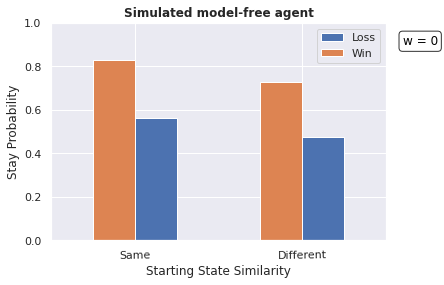

In [ ]:
# Run model-based agent and plot the data 
n_trials = 200
alpha = 0.5
beta = 4
w = 0

# to print correct title on plot
if w == 0:
    behave = 'model-free'
elif w == 1:
    behave = 'model-based'
else:
    behave = 'mixture'

[stay, state_sim, prev_rews, rewards] = mb_mf_agent(n_trials, alpha, beta, w)

# calculate probabilities
df = pd.DataFrame({"Rocket_State_Sim":state_sim,"Previous_Rewards":prev_rews,"Stay":stay})
plot_data = df.groupby(["Rocket_State_Sim","Previous_Rewards"]).mean().unstack()
a = plot_data.reset_index()

# plot the graph
fig, ax = plt.subplots()
a.plot(x = "Rocket_State_Sim", kind="bar", ylim = [0,1],
       stacked=False,ax=ax)

# figure legends
ax.legend(["Loss","Win"])
ax.set_ylabel("Stay Probability")
plt.xticks(rotation=1)
ax.set_xticklabels(['Different','Same'])
ax.set_xlabel("Starting State Similarity")
ax.invert_xaxis()

# title corresponding to w value
ax.set_title(f'Simulated {behave} agent', fontweight='bold')

# text bubble for w according to value
ax.text(-0.6,0.9, f'w = {w}', color = 'black', size=12,
       bbox=dict(facecolor='white', alpha=0.8, edgecolor='black', boxstyle = 'round'))

plt.show()

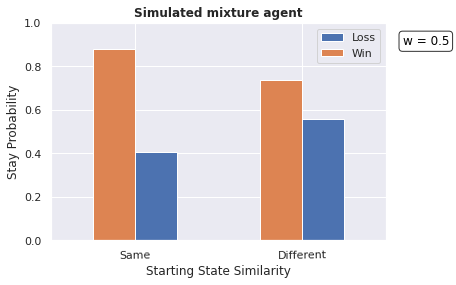

In [ ]:
# Run mixture agent and plot the data 
n_trials = 200
alpha = 0.5
beta = 4
w = 0.5

# to print correct title on plot
if w == 0:
    behave = 'model-free'
elif w == 1:
    behave = 'model-based'
else:
    behave = 'mixture'

[stay, state_sim, prev_rews, rewards] = mb_mf_agent(n_trials, alpha, beta, w)

# calculate probabilities
df = pd.DataFrame({"Rocket_State_Sim":state_sim,"Previous_Rewards":prev_rews,"Stay":stay})
plot_data = df.groupby(["Rocket_State_Sim","Previous_Rewards"]).mean().unstack()
a = plot_data.reset_index()

# plot the graph
fig, ax = plt.subplots()
a.plot(x = "Rocket_State_Sim", kind="bar", ylim = [0,1],
       stacked=False,ax=ax)

# figure legends
ax.legend(["Loss","Win"])
ax.set_ylabel("Stay Probability")
plt.xticks(rotation=1)
ax.set_xticklabels(['Different','Same'])
ax.set_xlabel("Starting State Similarity")
ax.invert_xaxis()

# title corresponding to w value
ax.set_title(f'Simulated {behave} agent', fontweight='bold')

# text bubble for w according to value
ax.text(-0.6,0.9, f'w = {w}', color = 'black', size=12,
       bbox=dict(facecolor='white', alpha=0.8, edgecolor='black', boxstyle = 'round'))

plt.show()

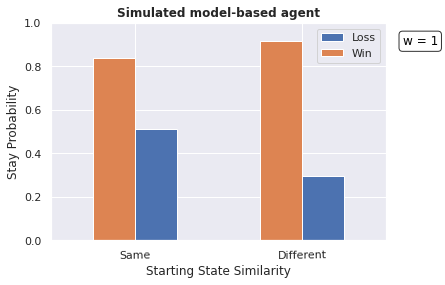

In [ ]:
# Run an model-less agent and plot the data
n_trials = 200
alpha = 0.5
beta = 4
w = 1

# to print correct title on plot
if w == 0:
    behave = 'model-free'
elif w == 1:
    behave = 'model-based'
else:
    behave = 'mixture'

[stay, state_sim, prev_rews, rewards] = mb_mf_agent(n_trials, alpha, beta, w)

# calculate probabilities
df = pd.DataFrame({"Rocket_State_Sim":state_sim,"Previous_Rewards":prev_rews,"Stay":stay})
plot_data = df.groupby(["Rocket_State_Sim","Previous_Rewards"]).mean().unstack()
a = plot_data.reset_index()

# plot the graph
fig, ax = plt.subplots()
a.plot(x = "Rocket_State_Sim", kind="bar", ylim = [0,1],
       stacked=False,ax=ax)

# figure legends
ax.legend(["Loss","Win"])
ax.set_ylabel("Stay Probability")
plt.xticks(rotation=1)
ax.set_xticklabels(['Different','Same'])
ax.set_xlabel("Starting State Similarity")
ax.invert_xaxis()

# title corresponding to w value
ax.set_title(f'Simulated {behave} agent', fontweight='bold')

# text bubble for w according to value
ax.text(-0.6,0.9, f'w = {w}', color = 'black', size=12,
       bbox=dict(facecolor='white', alpha=0.8, edgecolor='black', boxstyle = 'round'))

plt.show()

In [ ]:
n_trials = 500
alphas = np.arange(11,step=2) / 10
betas = np.arange(60, step=10) / 10
data = np.array(np.meshgrid(alphas, betas)).T.reshape(-1, 2)
results = np.zeros((len(data),6))

for index,(alpha,beta) in enumerate(data):
# Simulate a model-based agent and check performance
  w = 1
  [stay, state_sim, prev_rews, mb_rewards] = mb_mf_agent(n_trials, alpha, beta, w)
  mb_score = sum(mb_rewards)*100 / n_trials

  # Simulate a model-free agent and check performance
  w = 0
  [stay, state_sim, prev_rews, mf_rewards] = mb_mf_agent(n_trials, alpha, beta, w)
  mf_score = sum(mf_rewards)*100 / n_trials

  # Simulate a mixture agent and check performance
  w = 0.5
  [stay, state_sim, prev_rews, mix_rewards] = mb_mf_agent(n_trials, alpha, beta, w)
  mix_score = sum(mix_rewards)*100 / n_trials


  results[index][0] = alpha
  results[index][1] = beta
  results[index][2] = round(mb_score - mf_score,2)
  results[index][3] = round(mb_score,2)
  results[index][4] = round(mf_score,2)
  results[index][5] = round(mix_score,2)


df = pd.DataFrame(results,columns=["Alpha","Beta", "Performance Gain", "MB Score", "MF Score", "Mix Score"] )

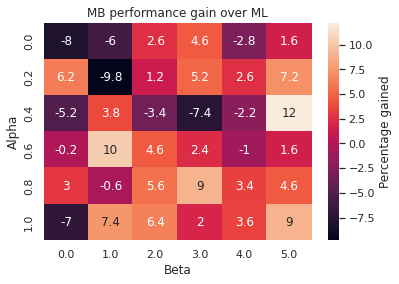

In [ ]:

#Plot heatmap of performance gain MB has over ML for every combination of alpha en beta values
pivoted_df  = df.pivot("Alpha","Beta", "Performance Gain")
ax = sns.heatmap(pivoted_df,annot=True,cbar_kws={'label': 'Percentage gained'})
ax.set_title("MB performance gain over ML")
plt.show()

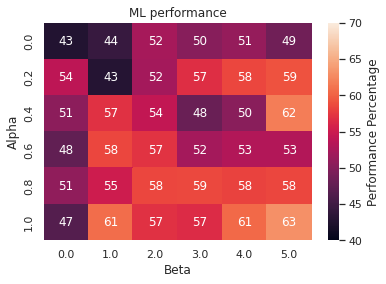

In [ ]:
#Plot heatmap of performance ML for every combination of alpha en beta values
pivoted_df  = df.pivot("Alpha","Beta", "MB Score")
ax = sns.heatmap(pivoted_df, annot=True, vmin=40, vmax=70, cbar_kws={'label': 'Performance Percentage'})
ax.set_title("ML performance")
plt.show()

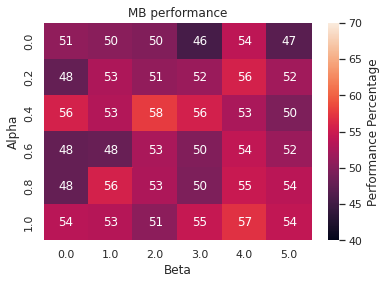

In [ ]:
#Plot heatmap of performance ML for every combination of alpha en beta values
pivoted_df  = df.pivot("Alpha","Beta", "MF Score")
ax = sns.heatmap(pivoted_df, annot=True, vmin=40, vmax=70, cbar_kws={'label': 'Performance Percentage'})
ax.set_title("MB performance")
plt.show()

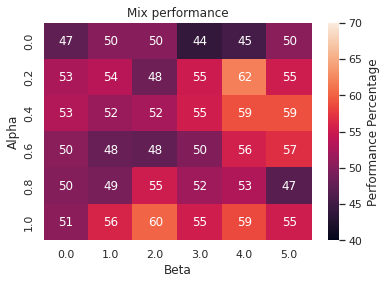

In [ ]:
#Plot heatmap of performance ML for every combination of alpha en beta values
pivoted_df  = df.pivot("Alpha","Beta", "Mix Score")
ax = sns.heatmap(pivoted_df, annot=True, vmin=40, vmax=70, cbar_kws={'label': 'Performance Percentage'})
ax.set_title("Mix performance")
plt.show()